In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Apache Beam RunInference with TensorFlow and TensorflowHub

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/run_inference_tensorflow_with_tensorflowhub.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/run_inference_tensorflow_with_tensorflowhub.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>


This notebook demonstrates the use of the RunInference transform for [TensorFlow](https://www.tensorflow.org/).
Beam [RunInference](https://beam.apache.org/releases/pydoc/current/apache_beam.ml.inference.base.html#apache_beam.ml.inference.base.RunInference) accepts a Tensorflow Model Handler either [TFModelHandlerNumpy](https://github.com/apache/beam/blob/ca0787642a6b3804a742326147281c99ae8d08d2/sdks/python/apache_beam/ml/inference/tensorflow_inference.py#L91) or [TFModelHandlerTensor](https://github.com/apache/beam/blob/ca0787642a6b3804a742326147281c99ae8d08d2/sdks/python/apache_beam/ml/inference/tensorflow_inference.py#L184) depending upon the type of the input.

The Apache Beam RunInference transform is used to make predictions for
a variety of machine learning models. For more information about the RunInference API, see [Machine Learning](https://beam.apache.org/documentation/sdks/python-machine-learning) in the Apache Beam documentation.

This notebook demonstrates the following steps:
- Build a simple TensorFlow model.
- Set up example data.
- Run those examples and get a prediction inside an Apache Beam pipeline.
- Run an inference pipeline by using a trained model from tensorflow hub.

## Before you begin
Complete the following setup steps.

First, import `tensorflow`.

In [ ]:
!pip install tensorflow
!pip install apache_beam==2.46.0

To use RunInference with Tensorflow Model Handler, install Apache Beam version 2.46 or later.

In [3]:
!pip freeze | grep beam

apache-beam==2.46.0


### Authenticate with Google Cloud
This notebook relies on saving your model to Google Cloud. To use your Google Cloud account, authenticate this notebook.

In [ ]:
from google.colab import auth
auth.authenticate_user()

### Import dependencies and set up your bucket
Replace `PROJECT_ID` and `BUCKET_NAME` with the ID of your project and the name of your bucket.

**Important**: If an error occurs, restart your runtime.

In [4]:
import argparse

import tensorflow as tf
from tensorflow import keras

import numpy

import apache_beam as beam
from apache_beam.ml.inference.base import RunInference
from apache_beam.options.pipeline_options import PipelineOptions

project = "PROJECT_ID"
bucket = "BUCKET_NAME"

save_model_dir_multiply = f'gs://{bucket}/tfx-inference/model/multiply_five/v1/'


## Create and test a simple model

This step creates and tests a model that predicts the 5 times table.

### Create the model
Create training data and build a linear regression model.

In [ ]:
# Create training data that represents the 5 times multiplication table for the numbers 0 to 99.
# x is the data and y is the labels.
x = numpy.arange(0, 100)   # Examples
y = x * 5                  # Labels

# Build a simple linear regression model.
# Note that the model has a shape of (1) for its input layer and expects a single int64 value.
input_layer = keras.layers.Input(shape=(1), dtype=tf.float32, name='x')
output_layer= keras.layers.Dense(1)(input_layer)

model = keras.Model(input_layer, output_layer)
model.compile(optimizer=tf.optimizers.Adam(), loss='mean_absolute_error')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### Test the model

This step tests the model that you created.

In [ ]:
model.fit(x, y, epochs=500, verbose=0)
test_examples =[20, 40, 60, 90]
value_to_predict = numpy.array(test_examples, dtype=numpy.float32)
predictions = model.predict(value_to_predict)

print('Test Examples ' + str(test_examples))
print('Predictions ' + str(predictions))

1/1 [==============================] - 0s 62ms/step
Test Examples [20, 40, 60, 90]
Predictions [[ 24.687366]
 [ 47.377365]
 [ 70.06737 ]
 [104.10237 ]]


### Save the model

This step shows how to save your model.

In [ ]:
model.save(save_model_dir_multiply)

## Run the Pipeline
Use the following code to run the pipeline.

In [ ]:
from apache_beam.ml.inference.tensorflow_inference import TFModelHandlerNumpy
import apache_beam as beam

class FormatOutput(beam.DoFn):
  def process(self, element, *args, **kwargs):
     yield "example is {example} prediction is {prediction}".format(example=element.example, prediction=element.inference)


examples = numpy.array([20, 40, 60, 90], dtype=numpy.float32)
model_handler = TFModelHandlerNumpy(save_model_dir_multiply)
with beam.Pipeline() as p:
    _ = (p | beam.Create(examples)
           | RunInference(model_handler)
           | beam.ParDo(FormatOutput())
           | beam.Map(print)
        )

example is 20.0 prediction is [24.687366]
example is 40.0 prediction is [47.377365]
example is 60.0 prediction is [70.06737]
example is 90.0 prediction is [104.10237]


## KeyedModelHandler with TensorFlow

By default, the `ModelHandler` does not expect a key.

* If you know that keys are associated with your examples, wrap the model handler with `beam.KeyedModelHandler`.
* If you don't know whether keys are associated with your examples, use `beam.MaybeKeyedModelHandler`.

In [ ]:
from apache_beam.ml.inference.base import KeyedModelHandler
from google.protobuf import text_format
import tensorflow as tf

class FormatOutputKeyed(FormatOutput):
  # To simplify, inherit from FormatOutput.
  def process(self, tuple_in: Tuple):
    key, element = tuple_in
    output = super().process(element)
    yield "{} : {}".format(key, output)

examples = numpy.array([(1,20), (2,40), (3,60), (4,90)], dtype=numpy.float32)
keyed_model_handler = KeyedModelHandler(TFModelHandlerNumpy(save_model_dir_multiply))
with beam.Pipeline() as p:
    _ = (p | 'CreateExamples' >> beam.Create(examples)
           | RunInference(keyed_model_handler)
           | beam.ParDo(FormatOutputKeyed())
           | beam.Map(print)
        )

1.0 : example is 20.0 prediction is [24.687366]
2.0 : example is 40.0 prediction is [47.377365]
3.0 : example is 60.0 prediction is [70.06737]
4.0 : example is 90.0 prediction is [104.10237]


## RunInference with Tensorflow Hub

To use tensorflow hub's trained model URL, pass it to the `model_uri` field of TFModelHandler class.

In [ ]:
import tensorflow_hub as hub

In [ ]:
# URL of the trained model from tensorflow hub
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

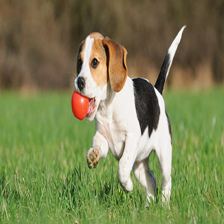

In [ ]:
import numpy as np
import PIL.Image as Image

IMAGE_RES = 224
img = tf.keras.utils.get_file(origin='https://images-na.ssl-images-amazon.com/images/G/01/img15/pet-products/small-tiles/23695_pets_vertical_store_dogs_small_tile_8._CB312176604_.jpg')
img = Image.open(img).resize((IMAGE_RES, IMAGE_RES))
img

In [ ]:
img = np.array(img)/255.0
img.shape

(224, 224, 3)

In [ ]:
img_tensor = tf.cast(tf.convert_to_tensor(img[...]), dtype=tf.float32)
img_tensor.shape

TensorShape([224, 224, 3])

In [ ]:
from apache_beam.ml.inference.tensorflow_inference import TFModelHandlerTensor
from apache_beam.ml.inference.base import PredictionResult
from typing import Iterable

model_handler = TFModelHandlerTensor(model_uri=CLASSIFIER_URL)

class PostProcessor(beam.DoFn):
  """Process the PredictionResult to get the predicted label.
  Returns predicted label.
  """
  def process(self, element: PredictionResult) -> Iterable[str]:
    predicted_class = np.argmax(element.inference)
    labels_path = tf.keras.utils.get_file(
        'ImageNetLabels.txt',
        'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
    )
    imagenet_labels = numpy.array(open(labels_path).read().splitlines())
    predicted_class_name = imagenet_labels[predicted_class]
    yield predicted_class_name.title()

with beam.Pipeline() as p:
  _ = (p | beam.Create([img_tensor])
         | RunInference(model_handler)
         | beam.ParDo(PostProcessor())
         | beam.Map(print)
      )

Beagle
